The goal of this notebook is to recalibrate the intercepts of the baseline and cohort afib models and the age coefficient of the cohort afib model and the afib cohort model itself, so that the simulation reproduces
the global burdain of disease estimates for atrial fibrilation and fluttering prevalence for 2019 in the US. 

Baseline intercept: 
This notebook manually modifies the intercept of the model, obtains an updated estimate of the afib prevalence and then adjusts the
intercept accordingly. A fixed number of iterations is used and empirically we verify that the choice of intercept steps, which
adjust during the iterations, are reasonable. The metric used to define the difference between the GBD and the simulation was using the afib prevalence that are the highest among the population (ie older ages). No attempt was made to map this metric to a change in the intercept model (ie use a slope and a change to find the change in the intercept as is done in the Newton method). The initial change in the intercept was found empirically.

Cohort intercept, age coefficient and model: something similar, but not identical is done. The difference here with the other notebook is that the adjustment for the intercept and age coefficient takes place simultaneously whereas in the other notebook the intercept was adjusted first and then the age coefficient.

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt
import importlib.util

In [2]:
from microsim.data_loader import load_model_spec, load_regression_model
from microsim.population import NHANESDirectSamplePopulation, initializeAFib
from microsim.sim_settings import simSettings
from microsim.statsmodel_logistic_risk_factor_model import StatsModelLogisticRiskFactorModel
from microsim.cohort_risk_model_repository import CohortRiskModelRepository
from microsim.stats_model_linear_probability_risk_factor_model import (StatsModelLinearProbabilityRiskFactorModel)
from microsim.statsmodel_linear_risk_factor_model import StatsModelLinearRiskFactorModel

In [3]:
gbdData=pd.read_csv("/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA/IHME-GBD_2019_DATA-afib/IHME-GBD_2019_DATA-8086e0fc-1.csv")
#gbdData.head(3)

In [4]:
gbdData.loc[ (gbdData["metric_name"]=="Percent") & (gbdData["age_id"].isin([16,17,18,19,20,30,31,32,235])),["age_id","age_name","val"]]

,age_id,age_name,val
31,16,55-59 years,0.017813
34,17,60-64 years,0.031653
37,18,65-69 years,0.056925
40,19,70-74 years,0.094122
43,20,75-79 years,0.140805
46,30,80-84,0.190387
49,31,85-89,0.224202
52,32,90-94,0.237910
61,235,95+ years,0.227766


In [5]:
#the reference afib data will be based on the 2019 US GBD data
afibRef = gbdData.loc[ 
    (gbdData["metric_name"]=="Percent") & (gbdData["age_id"].isin([16,17,18,19,20,30,31,32,235]))
    ,["val"]]["val"].tolist()
#afibRef

In [6]:
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

seedSequence = np.random.SeedSequence()
rngStream = np.random.default_rng(seed=seedSequence)

In [7]:
intercept = load_regression_model("BaselineAFibModel")._coefficients["Intercept"]
interceptStep = 1
interceptChange = 0

popSize=50000

In [8]:
module = importlib.import_module("microsim.population")

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

In [9]:
if False: #decide if I will recalibrate the baseline afib model intercept or just use the one I found in the past
    
    #use this definition of the baseline afib model
    def initializeAFib(person):
        model = load_regression_model("BaselineAFibModel")
        statsModel = StatsModelLogisticRiskFactorModel(model)
        return statsModel.estimate_next_risk(person)

    setattr(module, "initializeAFib", initializeAFib)

    pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)

    #afibRisks = list()
    #for p in pop._people.iloc[:]:
    #    afibRisks += [p._afib[0]]
    #afibRisks

    #plt.hist(afibRisks,bins=10)
    #plt.show()

    #do the bin counting for the baseline model
    ageList = list()
    afibList = list()
    for p in pop._people.iloc[:]:
        ageList +=  p._age
        afibList += p._afib 
        pDone = len(ageList)
        if pDone%100000==0:
            print(pDone)
        
    baseAfib = pd.DataFrame(list(zip(ageList,afibList)), columns=["age","afib"])
    baseAfib["age"]=baseAfib["age"].astype('int')
    baseAfib["ageInterval"] = pd.cut(baseAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)

    baseAfibMeansByAgeGroup = baseAfib.groupby("ageInterval").agg({'afib' : 'mean'})
    baseAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  baseAfibMeansByAgeGroup.index.array]

    labels = baseAfibMeansByAgeGroup["labels"].values.tolist()[1:]
    values = [x[0] for x in baseAfibMeansByAgeGroup.values[1:]]
    reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

    fig, ax = plt.subplots()
    ax.bar(labels, values)
    for i in range(len(reference)):
        ax.scatter(labels[i],reference[i],color="black")
    plt.xlabel("age group")
    plt.ylabel("mean afib risk")
    plt.title("nhanes baseline afib model")
    plt.show()

    #find how far off we are from the GBD prevalence
    afibSim = baseAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
    afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
    afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)] #use the reference values as the weights
    afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
    afibDiffWeightedSum = sum( afibDiffWeighted)

    #define the change in the model intercept based on the difference
    if (afibDiffWeightedSum>0.):
        interceptChange += interceptStep
    else:
        interceptChange += -interceptStep
    
    #and now do this all over again
    for run in range(0,50):

        if (run%10==0):
            print(f"intercept= {intercept} step= {interceptStep} change= {interceptChange}")
        intercept += interceptChange
    
        def initializeAFib(person, intercept = intercept):
            model = load_regression_model("BaselineAFibModel")
            model._coefficients["Intercept"] = intercept
            #model._coefficients["age"] = model._coefficients["age"]*1
            statsModel = StatsModelLogisticRiskFactorModel(model)
            return statsModel.estimate_next_risk(person)

        setattr(module, "initializeAFib", initializeAFib)

        pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)

        ageList = list()
        afibList = list()
        for p in pop._people.iloc[:]:
            ageList +=  p._age
            afibList += p._afib 
            pDone = len(ageList)
            #if pDone%100000==0:
                #print(pDone)
        
        baseAfib = pd.DataFrame(list(zip(ageList,afibList)), columns=["age","afib"])
        baseAfib["age"]=baseAfib["age"].astype('int')
        baseAfib["ageInterval"] = pd.cut(baseAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)

        baseAfibMeansByAgeGroup = baseAfib.groupby("ageInterval").agg({'afib' : 'mean'})
        baseAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  baseAfibMeansByAgeGroup.index.array]

        afibSim = baseAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
        afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
        afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)]
        afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
        afibDiffWeightedSumOld = afibDiffWeightedSum
        afibDiffWeightedSum = sum( afibDiffWeighted)

        if (afibDiffWeightedSum*afibDiffWeightedSumOld<0) :
            interceptStep = interceptStep/2
        if (afibDiffWeightedSum>0.):
            interceptChange = interceptStep
        else:
            interceptChange = -interceptStep
    

In [10]:
#obtain the last updated intercept for the baseline model
intercept += interceptChange
#or use the one I found in the past
intercept = -9.090481572055563

#use this updated intercept from now on
def initializeAFib(person, intercept = intercept):
    model = load_regression_model("BaselineAFibModel")
    model._coefficients["Intercept"] = intercept
    #model._coefficients["age"] = model._coefficients["age"]*1
    statsModel = StatsModelLogisticRiskFactorModel(model)
    return statsModel.estimate_next_risk(person)

setattr(module, "initializeAFib", initializeAFib)

In [11]:
# -9.091369874977811 with population 500000 (and many many hours)
# -9.090481572055563 with population 50000 (and a few mins)
intercept

-9.090481572055563

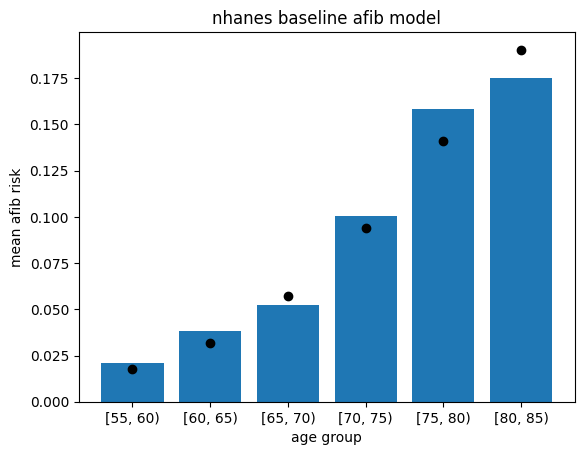

In [12]:
#let's see what results the latest intercept for the baseline cohort model gives

pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)

#do the bin counting for the baseline model
ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age
    afibList += p._afib 
    pDone = len(ageList)
    if pDone%100000==0:
        print(pDone)
        
baseAfib = pd.DataFrame(list(zip(ageList,afibList)), columns=["age","afib"])
baseAfib["age"]=baseAfib["age"].astype('int')
baseAfib["ageInterval"] = pd.cut(baseAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)

baseAfibMeansByAgeGroup = baseAfib.groupby("ageInterval").agg({'afib' : 'mean'})
baseAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  baseAfibMeansByAgeGroup.index.array]

labels = baseAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in baseAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes baseline afib model")
plt.show()

In [13]:
#we will do this now for the cohort afib model

#recalibrating the cohort afib model is much more demanding so reduce the population
popSize=10000

#the difference is that now we need to advance the population and use the data from all person-years
module = importlib.import_module("microsim.cohort_risk_model_repository")

#I tried adjusting just the intercept using the default statistics model (statsmodellinearprobability) but the results were not good
#so now I will adjust both at the same time and switch the model to one that does not depend on a comparison with 0.5
#I tried adjusting both the intercept and the age coefficient with the default approach but the results were also not great 
intercept = load_regression_model("afibCohortModel")._coefficients["Intercept"]
interceptStep = 0.25
interceptChange = 0

ageCoeff = load_regression_model("afibCohortModel")._coefficients["age"]
ageStep = 0.003
ageChange = 0

In [14]:
#define a model that draws from the uniform distribution to determine afib 
class StatsAfibModel(StatsModelLinearRiskFactorModel):
    def __init__(self, regression_model):
        super().__init__(regression_model, False)

    def estimate_next_risk(self, person, rng=None):
        #rng = np.random.default_rng(rng)
        linearRisk = super().estimate_next_risk(
            person
        )
        riskWithResidual = linearRisk + self.draw_from_residual_distribution(rng)
        return rng.uniform() < riskWithResidual 

    def estimate_next_risk_vectorized(self, x, rng=None):
        #rng = np.random.default_rng(rng)
        linearRisk = super().estimate_next_risk_vectorized(x)
        riskWithResidual = linearRisk + self.draw_from_residual_distribution(rng)
        return rng.uniform()  < riskWithResidual 

In [15]:
def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept, ageCoeff=ageCoeff):
    model = load_regression_model(modelName)
    if (referenceName=="afib"):
        model._coefficients["Intercept"] = intercept
        #model._coefficients["age"] = ageCoeff
        self._repository[referenceName] = StatsAfibModel(model)
        #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
        #print("intercept = ", intercept)
    else:
        self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
    #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)

CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
from microsim.cohort_risk_model_repository import CohortRiskModelRepository

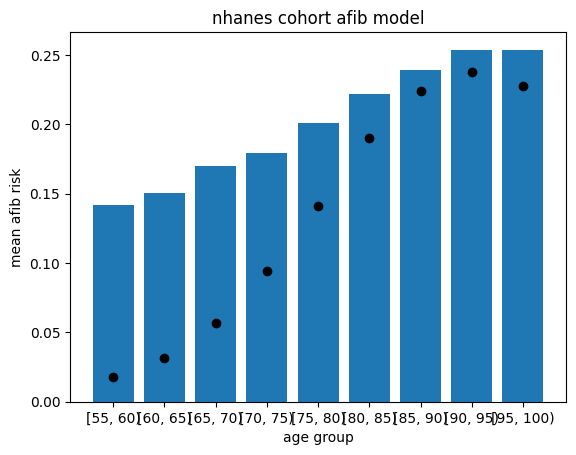

In [16]:
#let's see what this gives us without making any other changes
#so far I have only switched from statsmodellinearprobability to the statsafibmodel above
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
alive, dead = pop.advance_vectorized(150,rng=rngStream)

ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age[1:]
    afibList += p._afib[1:-1] 
    #pDone = len(ageList)
    #if pDone%100000==0:
     #   print(pDone)
        
cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
cohortAfib["afib"]=cohortAfib["afib"].astype('int')
cohortAfib["age"]=cohortAfib["age"].astype('int')

cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

labels = cohortAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in cohortAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes cohort afib model")
plt.show()

In [17]:
#find how far off we are from the GBD prevalence
afibSim = cohortAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)] #not using any weights this time
afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
afibDiffWeightedSum = sum( afibDiffWeighted)

#define the changes
if (afibDiffWeightedSum>0.):
    interceptChange += interceptStep
else:
    interceptChange += -interceptStep
    
if (afibDiffWeighted[-2]>afibDiffWeighted[2]):
    ageChange += ageStep
else:
    ageChange += -ageStep

In [18]:
for run in range(0,10):

    #if (run%10==0):
    print(f"run= {run} intercept= {intercept} step= {interceptStep} change= {interceptChange}")
    print(f"run= {run} ageCoeff= {ageCoeff} ageStep= {ageStep} ageChange= {ageChange}")
    ageCoeff += ageChange
    intercept += interceptChange
    
    def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept, ageCoeff=ageCoeff):
        model = load_regression_model(modelName)
        if (referenceName=="afib"):
            model._coefficients["Intercept"] = intercept
            #model._coefficients["age"] = ageCoeff
            self._repository[referenceName] = StatsAfibModel(model)
            #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
            #print("intercept = ", intercept)
        else:
            self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
        #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)

    CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
    setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
    from microsim.cohort_risk_model_repository import CohortRiskModelRepository
    
    pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
    alive, dead = pop.advance_vectorized(150,rng=rngStream)

    ageList = list()
    afibList = list()
    for p in pop._people.iloc[:]:
        ageList +=  p._age[1:]
        afibList += p._afib[1:-1] 
        #pDone = len(ageList)
        #if pDone%100000==0:
         #   print(pDone)
        
    cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
    cohortAfib["afib"]=cohortAfib["afib"].astype('int')
    cohortAfib["age"]=cohortAfib["age"].astype('int')

    cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
    cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
    cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

    
    afibSlopeDiffOld = afibDiffWeighted[-2] - afibDiffWeighted[2]
    afibSim = cohortAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
    afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
    afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)]
    #afibDiffWeighted = [y/x for x,y in zip(afibRef,afibDiff)]
    afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
    afibDiffWeightedSumOld = afibDiffWeightedSum
    afibDiffWeightedSum = sum( afibDiffWeighted)
    afibSlopeDiff = afibDiffWeighted[-2] - afibDiffWeighted[2]

    #there are differences here compared to the approach used with the baseline model
    if (afibDiffWeightedSum*afibDiffWeightedSumOld<0) :
        interceptStep = interceptStep/1.5
    if (afibDiffWeightedSum>0.):
        interceptChange = interceptStep
    else:
        interceptChange = -interceptStep
    
    #if (afibSlopeDiff*afibSlopeDiffOld<0) :
    ageStep = ageStep/1.25
    if (afibDiffWeighted[-2]>afibDiffWeighted[2]):
        ageChange = ageStep
    else:
        ageChange = -ageStep

run= 0 intercept= 0.006808684735369566 step= 0.25 change= -0.25
run= 0 ageCoeff= 0.0009656053138276052 ageStep= 0.003 ageChange= 0.003
run= 1 intercept= -0.24319131526463045 step= 0.16666666666666666 change= 0.16666666666666666
run= 1 ageCoeff= 0.003965605313827605 ageStep= 0.0024000000000000002 ageChange= 0.0024000000000000002
run= 2 intercept= -0.07652464859796379 step= 0.16666666666666666 change= 0.16666666666666666
run= 2 ageCoeff= 0.006365605313827605 ageStep= 0.0019200000000000003 ageChange= 0.0019200000000000003
run= 3 intercept= 0.09014201806870287 step= 0.1111111111111111 change= -0.1111111111111111
run= 3 ageCoeff= 0.008285605313827606 ageStep= 0.0015360000000000003 ageChange= -0.0015360000000000003
run= 4 intercept= -0.020969093042408238 step= 0.07407407407407407 change= 0.07407407407407407
run= 4 ageCoeff= 0.006749605313827606 ageStep= 0.0012288000000000002 ageChange= 0.0012288000000000002
run= 5 intercept= 0.05310498103166583 step= 0.04938271604938271 change= -0.0493827160

In [19]:
#obtain the last updated intercept for the cohort model
#(-0.2767233118132178, 0.004573159271391613) # treating all absolute diffs equally
#(-0.46616291512237573, 0.0072307910943804265) #treating all relative diffs equally
intercept += interceptChange
ageCoeff += ageChange
intercept, ageCoeff

(-0.0054226824342692315, 0.009639035125027605)

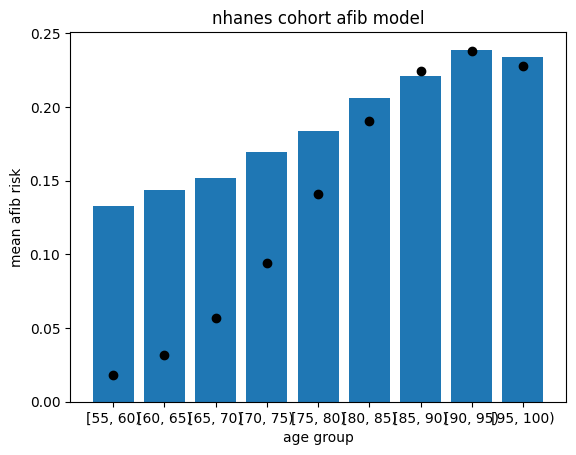

In [20]:
#now let's see what this recalibrated afib model gives us...
def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept, ageCoeff=ageCoeff):
        model = load_regression_model(modelName)
        if (referenceName=="afib"):
            model._coefficients["Intercept"] = intercept
            #model._coefficients["age"] = ageCoeff
            self._repository[referenceName] = StatsAfibModel(model)
            #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
            #print("intercept = ", intercept)
        else:
            self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
        #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)

CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
from microsim.cohort_risk_model_repository import CohortRiskModelRepository
    
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
alive, dead = pop.advance_vectorized(150,rng=rngStream)

ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age[1:]
    afibList += p._afib[1:-1] 
    #pDone = len(ageList)
    #if pDone%100000==0:
        #   print(pDone)
        
cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
cohortAfib["afib"]=cohortAfib["afib"].astype('int')
cohortAfib["age"]=cohortAfib["age"].astype('int')

cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

labels = cohortAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in cohortAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes cohort afib model")
plt.show()

In [ ]:
cohortAfibMeansByAgeGroup